In [1]:
import seaborn as sns
import torch
import numpy as np
import json

### Choose the root of KD
Find the original root directory of KD.

In [2]:
!ls ../save/student_datafree_model/

S:resnet8x4_T:resnet32x4_cifar100_kd_r:0.01_a:0.99_b:0.0_0_vae_lc_2
S:resnet8x4_T:resnet32x4_cifar100_kd_r:0.01_a:0.99_b:0.0_1_vae_lc_2
S:resnet8x4_T:resnet32x4_cifar100_kd_r:0.01_a:0.99_b:0.0_2_vae_lc_2
S:resnet8x4_T:resnet32x4_cifar100_kd_r:0.01_a:0.99_b:0.0_3_vae_lc_2
S:resnet8x4_T:resnet32x4_cifar100_kd_r:0.01_a:0.99_b:0.0_4_vae_lc_2
S:resnet8x4_T:resnet32x4_cifar100_kd_r:0.01_a:0.99_b:0.0_5_vae_lc_2
S:resnet8x4_T:resnet32x4_cifar100_kd_r:0.01_a:0.99_b:0.0_6_vae_lc_2
S:resnet8x4_T:resnet32x4_cifar100_kd_r:0.01_a:0.99_b:0.0_7_vae_lc_2
S:resnet8x4_T:resnet32x4_cifar100_kd_r:0.01_a:0.99_b:0.0_8_vae_lc_2
S:resnet8x4_T:resnet32x4_cifar100_kd_r:0.01_a:0.99_b:0.0_9_vae_lc_2
S:resnet8x4_T:resnet32x4_cifar100_kd_r:0.1_a:0.9_b:0.0_0_df_10000
S:resnet8x4_T:resnet32x4_cifar100_kd_r:0.1_a:0.9_b:0.0_0_df_30000
S:resnet8x4_T:resnet32x4_cifar100_kd_r:0.1_a:0.9_b:0.0_0_df_40000
S:resnet8x4_T:resnet32x4_cifar100_kd_r:0.1_a:0.9_b:0.0_0_df_50000
S:resnet8x4_T:resnet32x4_cifar100_kd_r:0.1_a:0.9_b:0.0_0

In [3]:
device = 'cuda:5'
ckpt_res = torch.load('../save/student_datafree_model/S:resnet8x4_T:resnet32x4_cifar100_kd_r:0.1_a:0.9_b:0.0_6_df_40000/resnet8x4_best.pth', map_location=device)
ckpt_res.keys()

ckpt_teacher = torch.load('/data/lijingru/EBKD/save/models/resnet32x4_vanilla/ckpt_epoch_240.pth', map_location=device)
ckpt_teacher.keys()

ckpt_energy = torch.load('/data/lijingru/EBKD/save/student_model/resnet28x10_cifar100_lr_0.0002_decay_0_buffer_size_40000_lpx_1.0_lpxy_0.0_energy_mode_mcmc_step_size_1_g_steps_20_trial_2/res_epoch_200.pts', map_location=device)
ckpt_energy.keys()

dict_keys(['model_state_dict', 'replay_buffer'])

In [4]:
import sys
sys.path.append('..')
from models.resnet import resnet8x4, resnet32x4
from models import model_dict

model_score = model_dict['resnet28x10'](num_classes=100, norm='none', depth=28, widen_factor=10)
model_score = model_dict['Gen'](model=model_score, n_cls=100)
model_score.load_state_dict(ckpt_energy['model_state_dict'])
model_score.to(device)
model_score.eval()

model = resnet8x4(num_classes=100, norm='batch')
model = model.to(device)
model.load_state_dict(ckpt_res['model'])
model.eval()

teacher = resnet32x4(num_classes=100, norm='batch')
teacher = teacher.to(device)
teacher.load_state_dict(ckpt_teacher['model'])
teacher.eval()

| Wide-Resnet 28x10


ResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

In [5]:
class Option:
    def __init__(self):
        self.device = device
        self.augment = False
        self.short_run = False
        self.g_steps = 40
        self.step_size = 1
        self.batch_size = 256
        self.reinit_freq = 0.05
        self.dataset = 'cifar100'
        self.n_cls = 100
        self.save_dir = './tmp/exp3/'
        self.save_folder = './tmp/'
        self.buffer_size = 40000
        self.save_grid = False

import os
opt = Option()
if not os.path.exists(opt.save_dir):
    os.mkdir(opt.save_dir)
    


In [9]:
from helper.sampling import langevin_at_x, init_random
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import tqdm
from helper.util import inception_score
from datasets.cifar100 import CIFAR100Gen
import torchvision.transforms as T
from helper.util_gen import cond_samples
 

sample_q = langevin_at_x(opts=opt, device=device)
# replay_buffer = ckpt_energy['replay_buffer'].cpu()
replay_buffer = init_random((opt.buffer_size, 3, 32, 32))
print(replay_buffer.shape)
y = torch.arange(0, opt.n_cls).to(device)

sqrt = lambda x: int(torch.sqrt(torch.Tensor([x])))
plot = lambda x: vutils.make_grid(torch.clamp(x, -1, 1), normalize=True, nrow=sqrt(x.size(0)))


torch.Size([40000, 3, 32, 32])


In [ ]:
freshh_epochs = 5001
for i in range(freshh_epochs):
    samples, _ = sample_q(model_score, replay_buffer, y=y)
    if i % 200 == 0:
        print('Epoch {} / {} ****'.format(i, freshh_epochs))
        buffer_size = len(replay_buffer)
        inds = torch.randint(0, buffer_size, (25,))
        sampled = replay_buffer[inds]
        imgs = plot(sampled).cpu()
        img = np.transpose(imgs, (1,2,0))
        plt.figure(10)
        plt.imshow(img)
        replay_buffer = cond_samples(model_score, replay_buffer, device, opt, use_buffer=True)
        test_folder = opt.save_dir
        dataset = CIFAR100Gen(
            root=test_folder,
            transform=T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])
        )
        mean, var = inception_score(dataset, device, resize=True, splits=3, batch_size=8)
        print('IS: {} +- {}'.format(mean, var))

Epoch 0 / 5001 ****


100%|██████████| 100/100 [08:52<00:00,  5.32s/it]


Successfully saving the generated result of replay buffer.


/data/lijingru/anaconda3/envs/torch/lib/python3.8/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


IS: 1.2600860801642468 +- 0.0010275184175406766


In [5]:
from torchvision.datasets import CIFAR100
from torchvision import transforms
from torch.utils.data import DataLoader
test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
test_set = CIFAR100(root='/data/lijingru/cifar100', download=False, train=False, transform=test_transform)
test_loader = DataLoader(test_set,
                         batch_size=1,
                         shuffle=False,
                         num_workers=1)

In [6]:
import tqdm
stu_incorrects = {'probs':[], 'energys':[]}
tea_incorrects = {'probs':[], 'energys':[]}
all_data = {'probs':[], 'energys':[]}

for idx, data in tqdm.tqdm(enumerate(test_loader)):
    x, y = data
    x = x.to(device)
    y = y.to(device)
    y_pred = model(x)
    y_pred_tea = teacher(x)
    energy = model_score(x, y=y)[0]
    all_data['energys'].append(energy.item())
#     all_data['data'].append(x[0].cpu().numpy().tolist())
    all_data['probs'].append(y_pred[0].detach().cpu().numpy().tolist())
    hard_y = y_pred.argmax(1)[0]
    hard_tea_y = y_pred_tea.argmax(1)[0]
#     print(hard_y, hard_tea_y, y)
    if hard_y != y[0]:
#         incorrects['data'].append(x[0].cpu().numpy())
        stu_incorrects['probs'].append(y_pred[0].detach().cpu().numpy().tolist())
        stu_incorrects['energys'].append(energy.item())
    if hard_tea_y != y[0]:
        tea_incorrects['probs'].append(y_pred_tea[0].detach().cpu().numpy().tolist())
        tea_incorrects['energys'].append(energy.item())
        
print('All data: {}'.format(len(all_data['probs'])))
print('Teacher incorrect: {}'.format(len(tea_incorrects['probs'])))
print('Student incorrect: {}'.format(len(stu_incorrects['probs'])))

10000it [04:27, 37.38it/s]

All data: 10000
Teacher incorrect: 2791
Student incorrect: 4807


In [7]:
import json
with open('all.json', 'w') as f:
    f.write(json.dumps(all_data, ensure_ascii=False, indent=4, separators=(',', ':')))
    
with open('incorrect_stu.json', 'w') as f:
    f.write(json.dumps(stu_incorrects, ensure_ascii=False, indent=4, separators=(',', ':')))
    
with open('incorrect_tea.json', 'w') as f:
    f.write(json.dumps(tea_incorrects, ensure_ascii=False, indent=4, separators=(',', ':')))

### Plot distribution of incorrect samples

In [2]:
with open('all.json', 'r') as f:
    all_data = json.load(f)
    
with open('incorrect_stu.json') as f:
    stu_incorrects = json.load(f)
    
with open('incorrect_tea.json') as f:
    tea_incorrects = json.load(f)

<AxesSubplot:ylabel='Density'>

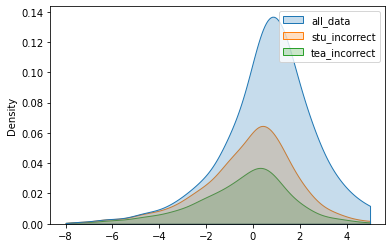

In [3]:
import seaborn as sns
sns.kdeplot(data={'all_data': all_data['energys'], 'stu_incorrect': stu_incorrects['energys'], 'tea_incorrect': tea_incorrects['energys']}, clip=(-8, 5), fill=True)

In [4]:
logos = ['k_10']
for logo in logos:
    scores = []
    for i in range(10):
        pths = torch.load('save/student_datafree_model/S:resnet8x4_T:resnet32x4_svhn_kd_r:0.4_a:0.6_b:0.0_{}_{}/resnet8x4_best.pth'.format(i, logo))
        acc = pths['best_acc']
        scores.append(acc.item())
    scores = np.asarray(scores)
    print('T:resnet32x4, S:resnet8x4, logo:{},  acc:{} +- {}'.format(logo, np.mean(scores), np.var(scores) ** 0.5))

T:resnet32x4, S:resnet8x4, logo:k_10,  acc:93.28749084472656 +- 0.17234420576255796


In [6]:
logos = [ 'df_10000', 'df_30000', 'df_40000', 'df_50000']
data = []
for logo in logos:
    scores = []
    for i in range(9):
        pths = torch.load('../save/student_datafree_model/S:resnet8x4_T:resnet32x4_cifar100_kd_r:0.1_a:0.9_b:0.0_{}_{}/resnet8x4_best.pth'.format(i, logo))
        acc = pths['best_acc']
        scores.append(acc.item())
    scores = np.asarray(scores)
    data.append(scores)
    print('T:resnet32x4, S:resnet8x4, logo:{},  acc:{} +- {}'.format(logo, np.mean(scores), np.var(scores) ** 0.5))

data = np.asarray(data)

T:resnet32x4, S:resnet8x4, logo:df_10000,  acc:36.04888788859049 +- 0.584873380242915
T:resnet32x4, S:resnet8x4, logo:df_30000,  acc:51.28666517469618 +- 1.144833721863551
T:resnet32x4, S:resnet8x4, logo:df_40000,  acc:52.15777672661675 +- 0.2561582599249095
T:resnet32x4, S:resnet8x4, logo:df_50000,  acc:55.84888797336154 +- 0.34728977793537


In [7]:
import pandas as pd
columns = [  'df_10000', 'df_30000', 'df_40000', 'df_50000']
real_data = pd.DataFrame(data=data.T, columns=columns)
real_data

,df_10000,df_30000,df_40000,df_50000
0,35.320000,48.099998,52.329998,56.340000
1,36.689999,51.270000,52.230000,55.539997
2,35.259998,51.699997,52.299999,56.239998
3,35.489998,51.759998,52.099998,55.559998
4,36.730000,51.579998,52.219997,55.820000
5,36.489998,51.879997,52.169998,55.930000
6,35.599998,51.789997,51.930000,55.840000
7,36.590000,51.500000,51.590000,55.209999
8,36.270000,52.000000,52.549999,56.160000


Text(0, 0.5, 'Student Acc.')

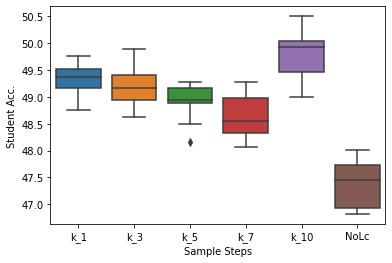

In [14]:
ax = sns.boxplot(data=real_data)
ax.set_xlabel('Sample Steps')
ax.set_ylabel('Student Acc.')